### Replication of Figures in the Paper

### Setup

In [1]:
import math
import os
import pickle

import imgkit
import matplotlib.pyplot as plt
import torch
from IPython.core.display import HTML, display
from transformer_lens import HookedTransformer, HookedTransformerConfig

from src import *

In [2]:
file_name = "dataset.txt"
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, file_name, n_examples)
pred = generate_example(16, 0, order="backward")

cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

Loading contents from file...


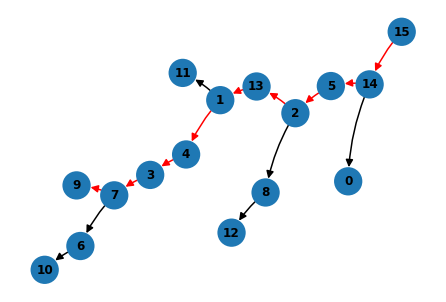

In [3]:
pred = generate_example(16, 1234, order="backward") #"10>3,10>14,3>7,3>1,7>6,6>13,7>5,1>15,15>9,14>4,14>8,4>0,0>2,0>11,8>12|9:10>3>1>15>9"
parse_example(pred)

In [4]:
assert is_model_correct(model, dataset, pred)
labels, cache = get_example_cache(pred, model, dataset)

for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Tuned Lens

In [5]:
def load_or_compute_tuned_lenses(model, dataset, filename='tuned_lenses.pkl'):
    # Check if the tuned lenses are already saved in the directory
    if os.path.exists(filename):
        # Load the tuned lenses from the pickle file
        with open(filename, 'rb') as file:
            lenses = pickle.load(file)
        print(f'Loaded tuned lenses from {filename}')
    else:
        # Calculate the tuned lenses
        lenses = calculate_tuned_lens(model, dataset)
        # Save the computed tuned lenses to the directory in pickle format
        with open(filename, 'wb') as file:
            pickle.dump(lenses, file)
        print(f'Saved tuned lenses to {filename}')
    
    return lenses

def backtracking_viz_proj(pred, model, dataset, lenses=None, pos=47):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    data = []
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = (out_proj*6).softmax(dim=-1)[pos]
        lens_out = [(dataset.idx2tokens[i], out_proj[i].item()) for i in range(9, 19)] + [(dataset.idx2tokens[i], out_proj[i].item()) for i in range(3, 9)]
        data.append([f"Layer {layer} Lens"] + lens_out)
    
    # Generate table
    # Initialize the rows for text and background color
    colors = [[] for _ in data]  # The first column will be white for layer names

    # Go through each layer's data, and populate the text and colors
    for i, layer in enumerate(data):
        for cond, val in layer[1:]:
            
            # Calculate a color based on the value, interpolating between white (0) and deep blue (1)
            colors[i].append(val)
    
    # Set up a matplotlib figure with 3x2 subplots
    fig, axs = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)  # 3 rows, 2 columns for 6 graphs

    for i, layer in enumerate(colors):
        highlighted = []
        for node, logit in enumerate(layer):
            logit = 1-1*math.exp(-4*logit)
            highlighted.append((node, logit))
        ax = axs.flatten()[i]
        parse_example(pred, highlight_nodes=highlighted, ax=ax)
        ax.set_title(f"Layer {i+1}", fontsize=14, weight='bold')        
    
    # Adjust layout for better spacing
    #plt.tight_layout()
    return fig


In [6]:
lenses = load_or_compute_tuned_lenses(model, dataset)

Loaded tuned lenses from tuned_lenses.pkl


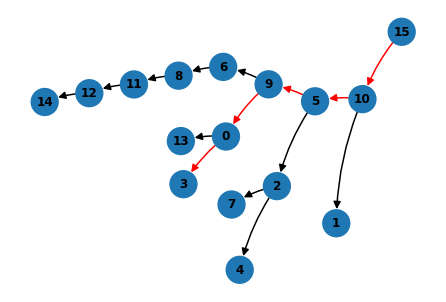

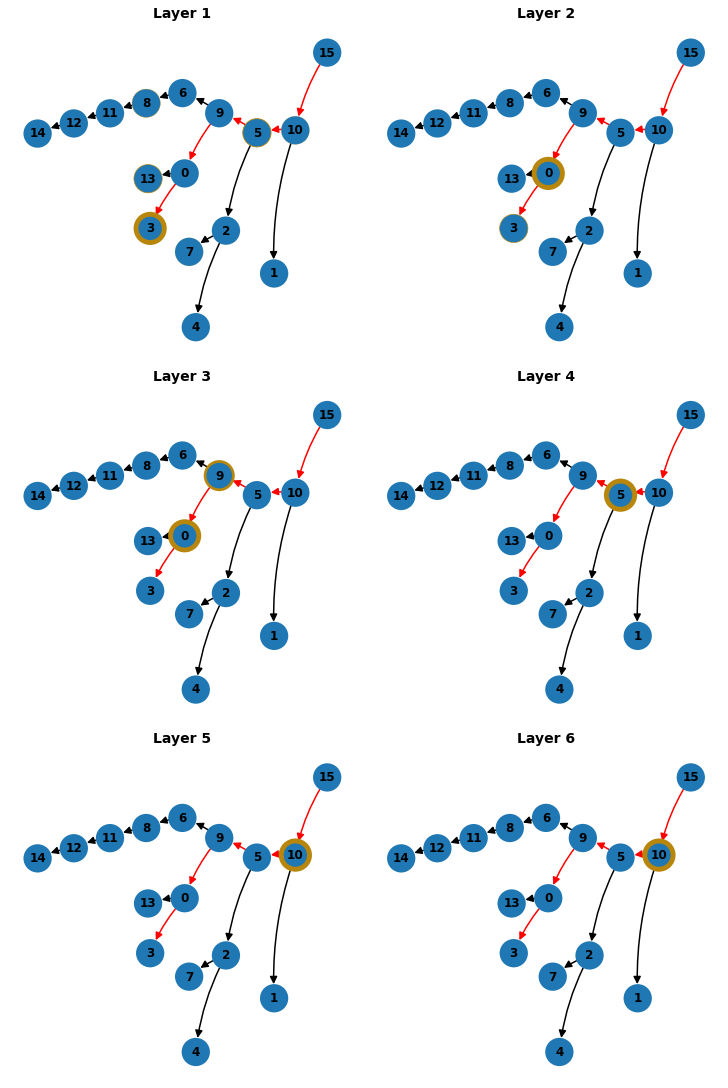

In [7]:
pred = generate_example(16, 89342568, path_length=5, order="backward")
parse_example(pred)
fig = backtracking_viz_proj(pred, model, dataset, lenses=lenses)
fig.savefig("images/length_5.png")

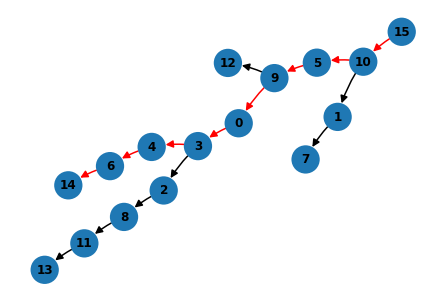

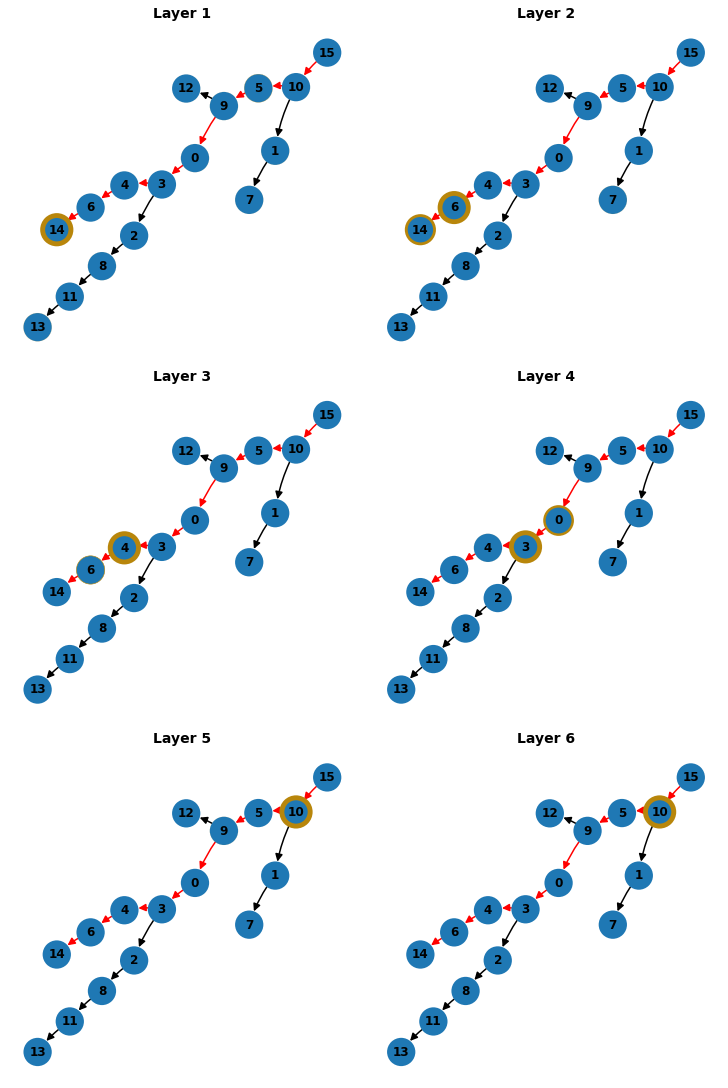

In [8]:
pred = generate_example(16, 89342568, path_length=8, order="backward")
parse_example(pred)
fig = backtracking_viz_proj(pred, model, dataset, lenses=lenses)
fig.savefig("images/length_8.png")

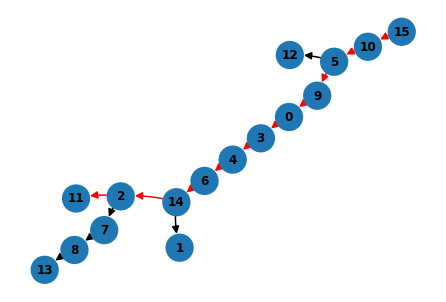

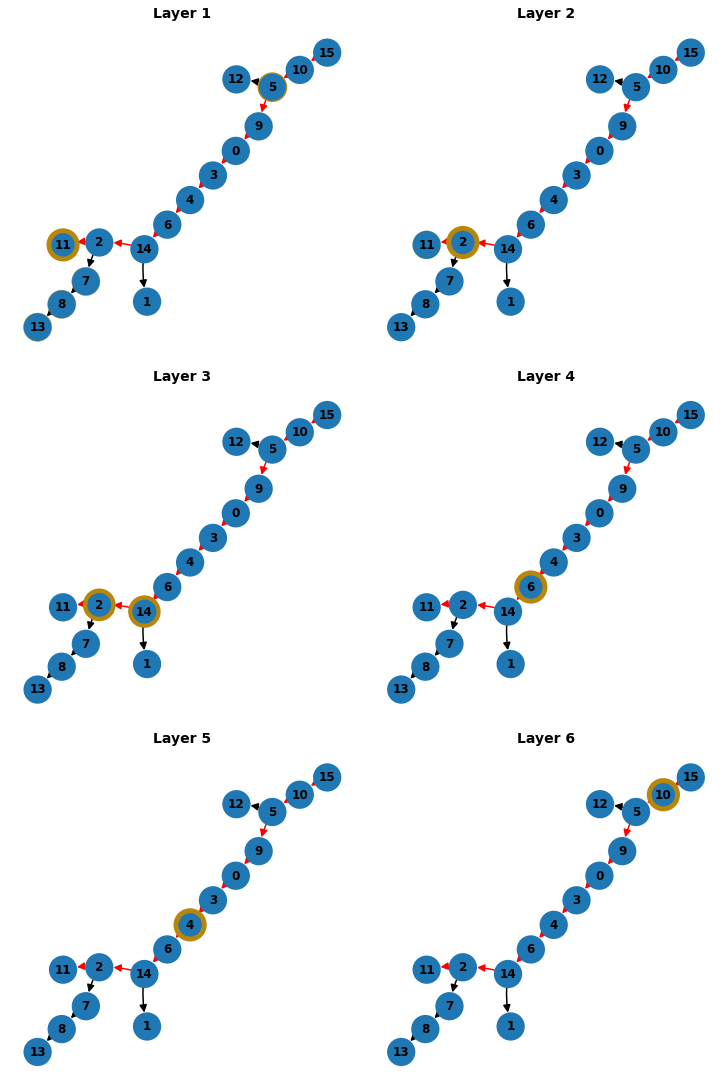

In [9]:
pred = generate_example(16, 89342568, path_length=10, order="backward")
parse_example(pred)
fig = backtracking_viz_proj(pred, model, dataset, lenses=lenses)
fig.savefig("images/length_10.png")

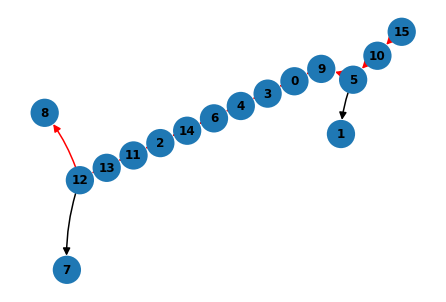

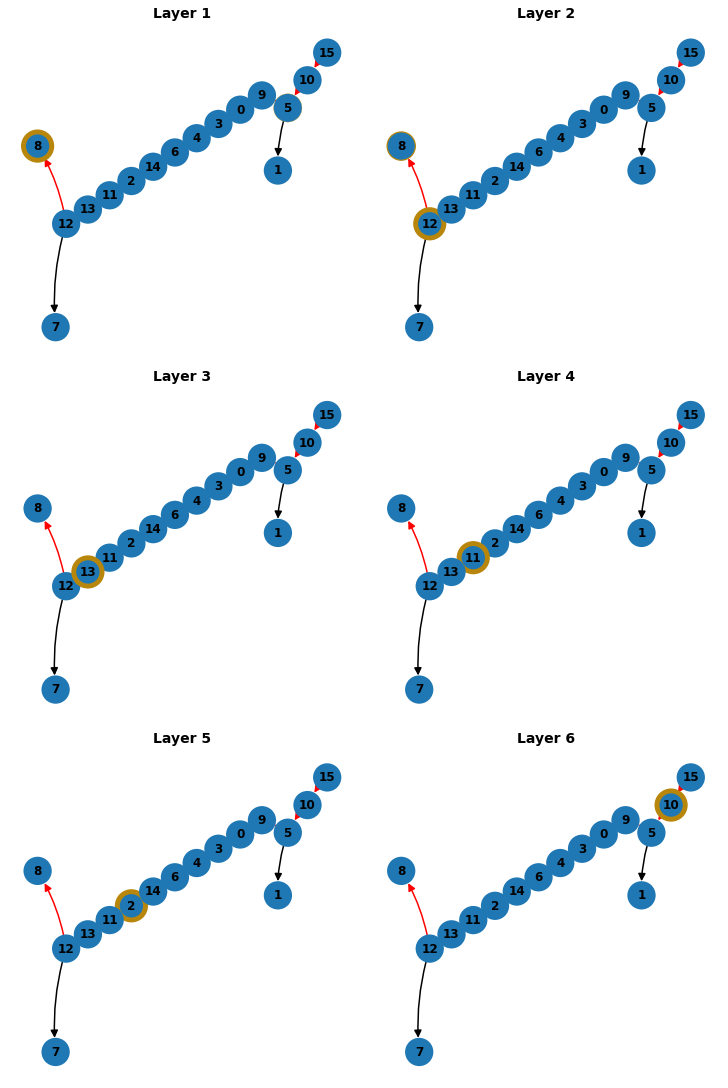

In [10]:
pred = generate_example(16, 89342568, path_length=13, order="backward")
parse_example(pred)
fig = backtracking_viz_proj(pred, model, dataset, lenses=lenses)
fig.savefig("images/length_13.png")

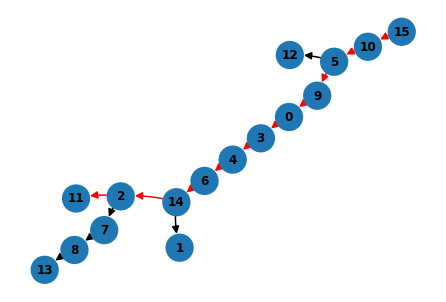

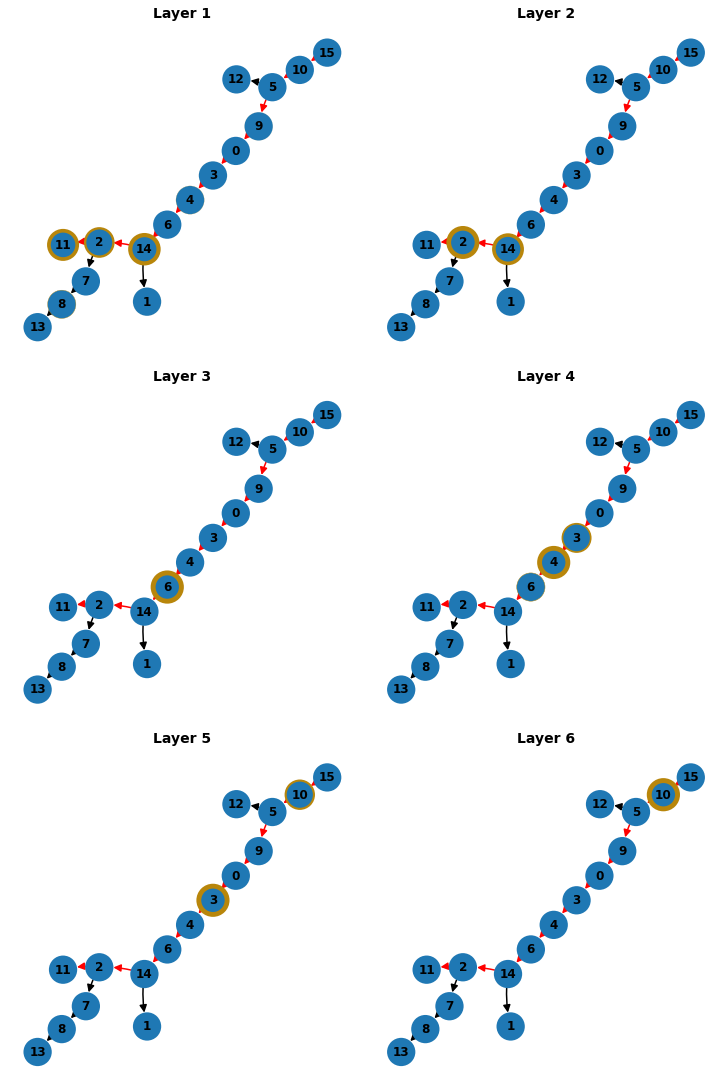

In [11]:
pred = generate_example(16, 89342568, path_length=10, order="backward")
parse_example(pred)
fig = backtracking_viz_proj(pred, model, dataset, lenses=lenses, pos=41)
fig.savefig("images/length_10.png")

### Attention Patterns

In [12]:
def create_table(table_data, header, file_name):
    # Formatting for the HTML
    css = """
    <style type="text/css">
        .content-wrapper {
            border: 1px solid #000;
            padding: 10px;
            display: inline-block;
            border-radius: 15px;
            font-family: Arial, sans-serif; /* Change font-family */
        }
        .header {
            font-weight: bold;
            text-align: center;
            background-color: #333;
            color: white; 
            margin: -10px;
            padding: 10px;
            border-top-left-radius: 14px;
            border-top-right-radius: 14px;
            font-size: 20px; /* Increase font size */
        }
        .header + .row {
            padding-top: 15px;
        }
        .row {
            padding: 5px 0;
            line-height: 1.5; /* Increase line height */
            font-size: 16px; /* Increase font size */
        }
    </style>
    """

    # Convert the table data to HTML with colored substrings
    html_content = '<div class="content-wrapper">'
    html_content += f'<div class="header">{header}</div>'

    for row in table_data:
        html_row = '<div class="row">'
        for text, color in row:
            if color:
                html_row += f"<span style='background-color: {color};'>{text}</span>"
            else:
                html_row += text
        html_row += '</div>'
        html_content += html_row

    html_content += '</div>'

    # Create the complete HTML with CSS
    html_str = f"<html><head>{css}</head><body>{html_content}</body></html>"
    display(HTML(html_str))

    # Generate the image using imgkit (assuming imgkit is properly configured)
    options = {
        'format': 'png',
        'quality': '100',
        'width': '140',
    }

    imgkit.from_string(html_str, file_name, options=options)


def generate_att_table(example, header, file_path, pos=47, norm=True):
    table_data = []
    labels, cache = get_example_cache(example, model, dataset)
    for i in range(6):
        pattern = cache[f"blocks.{i}.attn.hook_pattern"][0][0][pos].tolist()[:pos+1]
        if norm:
            pattern = [p / max(pattern) for p in pattern]
        pattern = [f"rgba(220, 20, 60, {min(1, p):.2f})" for p in pattern]
        row = list(zip(labels, pattern))
        table_data.append(row)
    create_table(table_data, header, file_path)

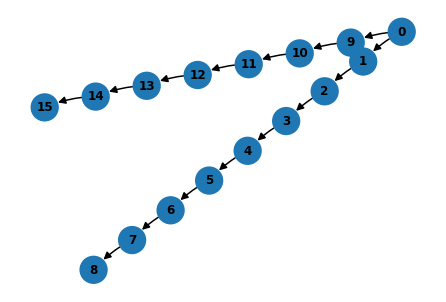

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [13]:
model.reset_hooks()

ex = "14>15,13>14,12>13,11>12,10>11,9>10,0>9,7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1|15:0"
pred, _ = eval_model(model, dataset, ex)
assert is_model_correct(model, dataset, pred)
parse_example(ex)
plt.show()
generate_att_table(ex, "Attention from the First Path Token", "images/backchaining_main.png", norm=True)

In [14]:
generate_att_table(ex, "Attention from the First Path Token", "images/backchaining_rp36.png", pos=36, norm=False)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [15]:
generate_att_table(ex, "Attention from the First Path Token", "images/backchaining_rp38.png", pos=38, norm=False)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [16]:
generate_att_table(ex, "Attention from the First Path Token", "images/backchaining_rp42.png", pos=42, norm=False)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


##### Causal Analysis of Subpaths


In [17]:
def attention_knockout_registers(model, dataset, test_graph, threshold=0.7):
    # Evaluate model on test_graph
    model.reset_hooks()
    correct, base_probs = is_model_correct(model, dataset, test_graph, return_probs=True)
    assert correct
    labels, cache = get_example_cache(test_graph, model, dataset)
    
    # Iterate over heads in each layer
    important = []
    ablated = []
    
    register_tokens = [36, 38, 39, 41, 42, 44, 45]
    
    for register in register_tokens:
        model.reset_hooks()
        
        for abl in ablated:
            # add_attention_blockout(model, 3, 0, 47, abl)
            add_attention_blockout(model, 4, 0, 47, abl)
            add_attention_blockout(model, 5, 0, 47, abl)

        # add_attention_blockout(model, 3, 0, 47, register)
        add_attention_blockout(model, 4, 0, 47, register)
        add_attention_blockout(model, 5, 0, 47, register)
    
        correct, new_probs = is_model_correct(model, dataset, test_graph, return_probs=True)
        score = kl_divergence(base_probs[0:1], new_probs[0:1])
                    
        if correct and (threshold is None or score < threshold):
            ablated.append(register)
        else:
            important.append(register)
                        
    return important


def find_largest_excluding_indices(tensor, exclude_indices):
    """
    Returns the index of the largest value in the tensor that is not in the specified indices to exclude.

    Parameters:
    - tensor (torch.Tensor): The input tensor.
    - exclude_indices (list or torch.Tensor): Indices to exclude from consideration.

    Returns:
    - int: The index of the largest value in the tensor excluding specified indices.
    """
    # Clone the tensor to avoid modifying the original tensor
    modified_tensor = tensor.clone()

    # Set the values at the excluded indices to negative infinity
    if isinstance(exclude_indices, list):
        exclude_indices = torch.tensor(exclude_indices, dtype=torch.long)
    modified_tensor[exclude_indices] = float('-inf')

    # Find the index of the largest value excluding the specified indices
    return modified_tensor.argmax().item()


def is_valid_path(dataset, graph, subpath):
    # Extract the adjacency matrix from the graph
    mat = extract_adj_matrix(graph)
    
    # Iterate through pairs of consecutive nodes in subpath
    for i in range(len(subpath) - 1):
        start, end = subpath[i], subpath[i + 1]
        
        # Check if these nodes are directly connected in the graph
        # Adjust the condition based on how your adjacency matrix is structured
        if mat[start][end] == 0:
            return False  # Early return if any pair is not directly connected
    
    # If all pairs are directly connected, return True
    return True


def view_subpath(dataset, graph, pos, max_layer=5):
    # Calculate the children of the root node
    tokens = dataset.tokenize(graph)[:-1]
    start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
    labels = [dataset.idx2tokens[idx] for idx in tokens]
    mat = extract_adj_matrix(graph)
    current_node = int( labels[start_idx-1].replace(">", "") )
    children = mat[current_node]
    # Calculate subpath from attention pattern
    node_order = []
    register_tokens = [36, 38, 39, 41, 42, 44, 45, 46]
    labels, cache = get_example_cache(graph, model, dataset)
    for i in range(max_layer):
        pattern = cache[f"blocks.{i}.attn.hook_pattern"][0][0][pos].tolist()[:pos+1]
        pattern_argmax = find_largest_excluding_indices(torch.tensor(pattern), [x for x in register_tokens if x < pos])
        if i == 0:
            try:
                node = int(labels[pattern_argmax])
            except:
                continue
        else:
            node = int(labels[pattern_argmax - 1])
            node_order.append(node)
        if children[node]:
            break
    # Create one hot encoding
    t = torch.zeros(16)
    for node in node_order:
        t[node] = 1
    return node_order[::-1], t

In [18]:
finding_cases = []
for i in range(500):
    model.reset_hooks()
    path_length = np.random.randint(7, 12)
    examples = generate_example_secondary_path(
        n_states=16,
        seed=np.random.randint(0, 1_000_000_000),
        path_length=9,
        second_path_min_length=6,
        order="random",
        return_all_leafs=True
    )
    for example in examples:
        try:
            important = attention_knockout_registers(model, dataset, example)
            #print(important)
            if len(important) > 0:
                finding_cases.append((example, important))
        except:
            pass
           # print("Failed")
model.reset_hooks()


In [19]:
for idx, (example, important) in enumerate(finding_cases):
    #parse_example(example)
    plt.show()
    subpath_pos = [47,]
    try:
        for i in important:
            subpath, _ = view_subpath(dataset, example, i)
            if is_valid_path(dataset, example, subpath):
                #print(i, subpath)
                if len(subpath) >= 3:
                    subpath_pos.append(i)
        if len(subpath_pos) > 1:
            print(idx, len(subpath_pos))
    except:
        pass

1 2
4 3
5 2
11 2
13 2
17 2
20 2
25 2
27 2
29 2
30 2
31 3
33 2
38 2
39 2
43 2
45 2
46 2
47 2
49 2
51 2
52 3
54 3
58 2
60 2
61 3
63 2
64 2
65 2
67 2
74 2
76 2
80 2
81 2
84 2
86 2
87 2
93 2
94 2
95 2
98 2
101 2
104 2
107 2
108 2
110 2
115 2
116 2
121 2
123 2
126 2
127 2
129 2


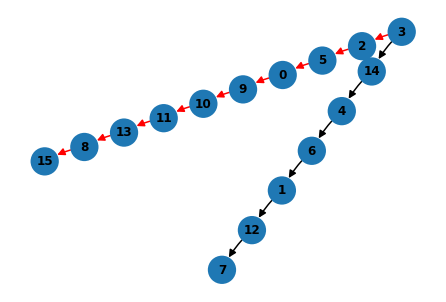

42 [5, 0, 9, 10]


In [20]:
example, important = finding_cases[86]
parse_example(example)
plt.show()
subpath_pos = [47,]
for i in important:
    subpath, _ = view_subpath(dataset, example, i)
    if is_valid_path(dataset, example, subpath):
        print(i, subpath)
        subpath_pos.append(i)

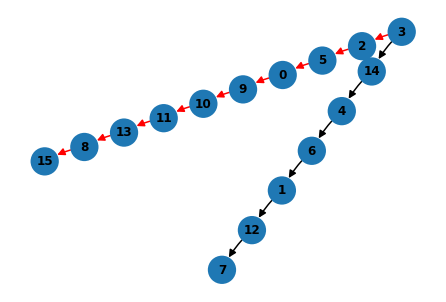

42 [5, 0, 9, 10]


In [21]:
example, important = finding_cases[86]
parse_example(example)
plt.show()
subpath_pos = [47,]
for i in important:
    subpath, _ = view_subpath(dataset, example, i)
    if is_valid_path(dataset, example, subpath):
        print(i, subpath)
        if len(subpath) > 2:
            subpath_pos.append(i)


def convert_to_latex(example, positions, norm=True):
    labels, cache = get_example_cache(example, model, dataset)
    colors = ["red", "blue", "green", "orange", "pink"]

    table = [[ [None, 0] for _ in range(max(positions)+1)] for _ in range(model.cfg.n_layers)]
    for pos in positions[::-1]:
        for layer in range(6):
            if layer >=4 and pos != 47:
                continue
            pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0][0][pos].tolist()[:pos+1]
            if norm:
                pattern = [p / max(pattern) for p in pattern]
            if pos!=47 and layer == 0:
                pattern = [int(p*100*0.8) for p in pattern]
            else:
                pattern = [int(p*100*2) for p in pattern]
            for ctx_pos, p in enumerate(pattern):
                if p >= table[layer][ctx_pos][1]:
                    table[layer][ctx_pos][0] = colors[positions.index(pos)]
                    table[layer][ctx_pos][1] = p
    
    latex_str = ""
    with open("latex.txt", "w") as f:
        for layer in range(len(table)):
            f.write("\n\hspace{-0.1cm}\n")
            for idx in range(len(table[layer])):
                label_name = labels[idx].replace(">", r"$\rightarrow$\,")
                if idx == len(table[layer]) - 1:
                    f.write("\hlfancy{" + table[layer][idx][0] + "!" + str(table[layer][idx][1]) + "}{" +  label_name + "}\\\\\n")
                else:
                    f.write("\hlfancy{" + table[layer][idx][0] + "!" + str(table[layer][idx][1]) + "}{" +  label_name + "}\n")
                if (idx + 2) % 3 == 0:
                    f.write("\hspace{-0.15cm}\n")

    
convert_to_latex(example, subpath_pos)

### Linear Probes/Concept Erasure

In [22]:
def linear_probe_all(X_train, y_train, X_test, y_test, mult=False):
    results = []
    for xkey in X_train.keys():    
        for ykey in y_train.keys():
            if mult:
                probe = LinearMultiClsProbe(max_iter=1000, learning_rate_init=1e-3, verbose=False)
                probe.fit(X_train[xkey].astype(np.float32), y_train[ykey].astype(np.float32))
                score = probe.score(X_test[xkey].astype(np.float32), y_test[ykey].astype(np.float32))
            else:            
                probe = LinearClsProbe(max_iter=100, learning_rate_init=1e-2, verbose=False)
                probe.fit(X_train[xkey].astype(np.float32), y_train[ykey].astype(np.int64))
                score = probe.score(X_test[xkey].astype(np.float32), y_test[ykey].astype(np.int64))
            print(f"{xkey} {ykey}", score)
            results.append( (xkey, ykey, score) )
    return results

In [23]:
def nonlinear_probe_all(X_train, y_train, X_test, y_test, mult=False):
    results = []
    for xkey in X_train.keys():    
        for ykey in y_train.keys():
            if mult:
                probe = NonlinearMultiClsProbe(max_iter=1000, learning_rate_init=1e-3, verbose=False)
                probe.fit(X_train[xkey].astype(np.float32), y_train[ykey].astype(np.float32))
                score = probe.score(X_test[xkey].astype(np.float32), y_test[ykey].astype(np.float32))
            else:            
                probe = NonlinearClsProbe(max_iter=100, learning_rate_init=1e-2, verbose=False)
                probe.fit(X_train[xkey].astype(np.float32), y_train[ykey].astype(np.int64))
                score = probe.score(X_test[xkey].astype(np.float32), y_test[ykey].astype(np.int64))
            print(f"{xkey} {ykey}", score)
            results.append( (xkey, ykey, score) )
    return results

In [24]:
def block_registers(registers=[36, 38, 39, 41, 42, 44, 46]):
    for pos in range(47, model.cfg.n_ctx):
        for layer in range(1, model.cfg.n_layers):
            for register in registers:
                add_attention_blockout(model, layer, 0, pos, register)
    
def block_leaves():
    for pos in range(0, 46):
        for layer in range(0, model.cfg.n_layers):
            add_attention_blockout(model, layer, 0, 46, pos)

##### Edge Aggregation in layer 0

In [ ]:
from sklearn import preprocessing


def generate_dataset():
    # Sample completions from model
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=["blocks.0.hook_resid_pre", "blocks.0.hook_resid_mid"],
        n_samples=1024
    )
    # Generate data
    newX = {}
    for key in X.keys():
        tensor_list = [ x[0, [i for i in range(45) if (i) % 3 == 0]] for x in X[key] ]
        newX[key.split('.')[2] + " outgoing"] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()
        
        tensor_list = [ x[0, [i for i in range(45) if (i-1) % 3 == 0]] for x in X[key] ]
        newX[key.split('.')[2] + " incoming"] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()
    # Generate labels
    y = {"incoming": [], "outgoing": []}
    for graph in graphs:
        tokens = dataset.tokenize(graph)[:-1]
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        y["outgoing"].append([labels[i-1] for i in range(45) if (i-1)%3 == 0])
        y["incoming"].append([labels[ i ] for i in range(45) if (i-1)%3 == 0])
    y["incoming"] = preprocessing.LabelEncoder().fit_transform( np.array(y["incoming"]).flatten() )
    y["outgoing"] = preprocessing.LabelEncoder().fit_transform( np.array(y["outgoing"]).flatten() )

    return newX, y


import warnings
warnings.filterwarnings('always')

X_train, y_train = generate_dataset()
X_test, y_test = generate_dataset()

results = linear_probe_all(X_train, y_train, X_test, y_test)

In [ ]:
 import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame(results, columns=['source', 'target', 'value'])
df["target"] = df["target"].str.replace("incoming", r"$B_i$").str.replace("outgoing", "$A_i$")
df["source"] = df["source"].str.replace("incoming", r"$B_i$").str.replace("outgoing", "$A_i$").str.replace("hook_resid_", "")


# Separate 'pre' and 'post' data
df_pre = df[df['source'].str.contains('pre')]
df_post = df[df['source'].str.contains('mid')]

df_pre["source"]= df_pre["source"].str.replace("pre ", "")
df_post["source"]= df_post["source"].str.replace("mid ", "")

# Pivot DataFrames to create a 2D structure for each one
heatmap_df_pre = df_pre.pivot("source", "target", "value")
heatmap_df_post = df_post.pivot("source", "target", "value")

# Set the style of the visualization
sns.set_style("white")

# Setup the color palette to be a gradient of blues
blue_cmap = sns.light_palette("#a275ac", as_cmap=True)

# Create subplots for side-by-side heatmaps with adjustable width_ratios
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.5})

# Plot heatmaps and maintain aspect ratio to make plots square
sns.heatmap(heatmap_df_pre, annot=True, fmt=".2f", cmap=blue_cmap, cbar=False, annot_kws={"size": 12}, ax=ax[0], square=True)
sns.heatmap(heatmap_df_post, annot=True, fmt=".2f", cmap=blue_cmap, cbar=False, annot_kws={"size": 12}, ax=ax[1], square=True)

# Improve the visibility of the heatmap
ax[0].set_title('Before Layer 1', pad=20, fontsize=18)
ax[1].set_title('After Layer 1', pad=20, fontsize=18)

# Rotate x-axis tick labels for both heatmaps (axis labeling is removed from here)
for axis in ax:
    
    axis.tick_params(axis='x', rotation=0, which='both', labelsize=16)
    axis.tick_params(axis='y', rotation=0, which='both', labelsize=16)

    # Remove the axis labels for a cleaner look
    axis.set_xlabel('')  # Remove the x-axis label
    axis.set_ylabel('')  # Remove the y-axis label 

# Set common axis labels for the entire figure instead of individual plots
fig.text(0.5, 0.04, 'Labels', ha='center', va='center', fontsize=18)
fig.text(0.04, 0.5, 'Inputs', ha='center', va='center', rotation='vertical', fontsize=18) 

# Remove axis ticks and spines for a cleaner look
sns.despine(left=True, bottom=True)

plt.tight_layout()  # Adjust the layout to fit better
plt.show()

fig.savefig("images/heatmaps1.png")


In [ ]:
print("A->(A,B) Before", results[1][-1] * results[0][-1])
print("B->(A,B) Before", results[3][-1] * results[2][-1])


print("A->(A,B) After", results[5][-1] * results[4][-1])
print("B->(A,B) Before", results[7][-1] * results[6][-1])


In [ ]:
X_train.keys()

In [ ]:
# Validate the causal importance of the linear probe
model.reset_hooks()
eraser = ConceptErasure(X_train["hook_resid_mid incoming"], y_train["outgoing"])
def leace_hook(activation, hook):
    scrubbed = eraser.predict(activation[:, 1:45:3].cpu())
    activation[:, 1:45:3] = scrubbed.cuda()
    return activation
model.blocks[0].hook_resid_mid.add_hook(leace_hook)


start_seed = 250_000
num_samples = 100

for path_length in range(1, 15):
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order="backward", path_length=path_length)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1
      else:
        pred, _ = eval_model(model, dataset, graph)
        plt.show()

  print(f"Length {path_length}: {100* total_correct / num_samples:.4f}%")

In [ ]:
ex = "14>15,13>14,12>13,11>12,10>11,9>10,0>9,7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1|15:0"
pred, _ = eval_model(model, dataset, ex)
print(pred)
parse_example(ex)
plt.show()
generate_att_table(ex, "Attention From First Path Token", "images/leaced_edge_backchaining.png", norm=False)

##### Goal aggregation in layer 0

In [ ]:
def generate_dataset():
    # Sample completions from model
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=["blocks.0.hook_resid_pre", "blocks.0.hook_resid_mid"],
        n_samples=1024
    )
    # Generate data
    newX = {}
    for key in X.keys():
        tensor_list = []
        for idx, graph in enumerate(graphs):
            tokens = dataset.tokenize(graph)[:-1]
            start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
            labels = [dataset.idx2tokens[idx] for idx in tokens]
            end_idx = num_last(labels, ",") + 1
            tensor_list.append(X[key][idx][0, start_idx-1:end_idx-1])
        newX[key] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()
        # Generate labels
    y = {"goal": []}
    for idx, graph in enumerate(graphs):
        # Tokenize graph
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        for label_idx in range(start_idx-1, end_idx - 1):
            y["goal"].append(int(labels[45]))
    y["goal"] = np.vstack(y["goal"]).flatten().astype(np.int64)
    return newX, y


X_train, y_train = generate_dataset()
X_test, y_test = generate_dataset()

results = linear_probe_all(X_train, y_train, X_test, y_test)

In [ ]:
# Create DataFrame
df = pd.DataFrame(results, columns=['source', 'target', 'value'])

df["source"] = df["source"].str.replace("path", "").str.replace("hook_resid_post ", "Path After \n Layer 1").str.replace("hook_resid_pre ", "Path Before \n Layer 1")
df["target"] = df["target"].str.replace("goal", "Goal")
heatmap_df = df.pivot("source", "target", "value")


# Set the style of the visualization
sns.set_style("white")

# Define the color map as a gradient of blues
blue_cmap = sns.light_palette("#a275ac", as_cmap=True)

# Plot heatmap; increase figure size for a larger display
fig = plt.figure(figsize=(4.8, 4.8))  # You can adjust the dimensions as needed
ax = sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap=blue_cmap, cbar=False, square=True, linewidths=.5)

# Improve the visibility of the heatmap
ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.tick_params(axis='y', which='both', length=0, labelsize=14)  # Hide y tick marks for cleanliness
ax.tick_params(axis='x', which='both', length=0, labelsize=14)  # Hide y tick marks for cleanliness

# Set common axis labels for the entire figure instead of individual plots
ax.text(0.42, 2.2, 'Labels', ha='center', va='center', fontsize=16)
ax.text(-0.7, 0.95, 'Inputs', ha='center', va='center', rotation='vertical', fontsize=16) 


# Remove the axis labels for a cleaner look
ax.set_xlabel('')  # Remove the x-axis label
ax.set_ylabel('')  # Remove the y-axis label  

# Remove axis ticks and spines for a cleaner look
sns.despine(left=True, bottom=True)

sns.despine(left=True, bottom=True)  # Remove borders for a cleaner look
plt.tight_layout()  # Adjust the layout to fit better
plt.show()

fig.savefig("images/heatmaps2.png")


In [ ]:
# Validate the causal importance of the linear probe
model.reset_hooks()
eraser = ConceptErasure(X_train["blocks.0.hook_resid_mid"], y_train["goal"])
def leace_hook(activation, hook):
    scrubbed = eraser.predict(activation[:, 47:].cpu())
    activation[:, 47:] = scrubbed.cuda()
    return activation
model.blocks[0].hook_resid_mid.add_hook(leace_hook)

start_seed = 250_000
num_samples = 100

for path_length in range(1, 15):
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order="backward", path_length=path_length)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1
      else:
        pred, _ = eval_model(model, dataset, graph)
        plt.show()

  print(f"Length {path_length}: {100* total_correct / num_samples:.4f}%")

In [ ]:
ex = "14>15,13>14,12>13,11>12,10>11,9>10,0>9,7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1|15:0"
pred, _ = eval_model(model, dataset, ex)
print(pred)
parse_example(ex)
plt.show()
generate_att_table(ex, "Attention From First Path Token", "images/leaced_goal_backchaining.png", norm=False)

##### Probe for children of current node

In [ ]:
from sklearn import preprocessing

model.reset_hooks()
block_registers()

def generate_dataset(n_samples, endshift=4):
    # Sample completions from model
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=["blocks.4.hook_resid_pre", "blocks.4.hook_resid_mid", "blocks.5.hook_resid_mid"],
        n_samples=n_samples,
        path_length=10
    )
    # Generate data
    newX = {}
    for key in X.keys():
        tensor_list = []
        for idx, graph in enumerate(graphs):
            tokens = dataset.tokenize(graph)[:-1]
            start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
            labels = [dataset.idx2tokens[idx] for idx in tokens]
            end_idx = num_last(labels, ",") + 1 - endshift
            if len(X[key][0].shape)==3:
                tensor_list.append(X[key][idx][0, start_idx-1:end_idx-1])
                #tensor_list = [ x[0, 47:48] for x in X[key] ]
            elif len(X[key][0].shape)==4:
                tensor_list.append(X[key][idx][0, start_idx-1:end_idx-1, 0])
                # tensor_list = [ x[0, 47:48, 0] for x in X[key] ]
        newX[key] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()

    # Generate labels
    y = {"leaves": [], "children":[]}
    for idx, graph in enumerate(graphs):
        # Tokenize graph
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1 - endshift
        mat = extract_adj_matrix(graph)
        leaves = find_leaf_nodes(graph)
        not_leaves = np.logical_not(leaves).astype(int)
        # Add all the children for each node in the path
        for label_idx in range(start_idx-1, end_idx - 1):
            current_node = int( labels[label_idx].replace(">", "") )
            children = mat[current_node]
            y["children"].append(children)
            y["leaves"].append(children & not_leaves) # Add the nodes that are both children and leaves

    y["leaves"] = np.vstack(y["leaves"])
    y["children"] = np.vstack(y["children"])

    return newX, y, graphs

X_train, y_train, train_graphs = generate_dataset(16384)
X_test, y_test, test_graphs = generate_dataset(4096)

results = linear_probe_all(X_train, y_train, X_test, y_test, mult=True)

In [ ]:
model.reset_hooks()

eraser = ConceptErasure(X_train["blocks.5.hook_resid_mid"], y_train["leaves"])
def leace_hook(activation, hook):
    scrubbed = eraser.predict(activation[:, 47:].cpu())
    activation[:, 47:] = scrubbed.cuda()
    return activation
model.blocks[5].hook_resid_mid.add_hook(leace_hook)

start_seed = 250_000
num_samples = 100

for path_length in range(1, 15):
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order="backward", path_length=path_length)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1
      else:
        pred, _ = eval_model(model, dataset, graph)
        plt.show()

  print(f"Length {path_length}: {100* total_correct / num_samples:.4f}%")

##### Probing for Subpaths


In [ ]:
finding_cases = []
for i in range(5000):
    model.reset_hooks()
    examples = generate_example_secondary_path(16, np.random.randint(0, 1_000_000_000), order="backward", return_all_leafs=True)
    for example in examples:
        try:
            important = attention_knockout_registers(model, dataset, example)
            #print(important)
            if len(important) > 0:
                finding_cases.append((example, important))
        except:
            pass
           # print("Failed")
model.reset_hooks()


In [ ]:

X = []
y = []

for example, important in finding_cases:
    try:
        for i in important:
            subpath, encoding = view_subpath(dataset, example, i)
            if is_valid_path(dataset, example, subpath):
                _, cache = get_example_cache(example, model, dataset)
                X.append(cache["blocks.5.hook_resid_pre"][0, i])
                y.append(encoding)
    except ValueError:
        pass

X = torch.stack(X)
y = torch.stack(y)

In [ ]:
from sklearn import preprocessing

split = int(X.shape[0]*0.8)
X_train = {"blocks.5.hook_resid_pre": X[:split].cpu().detach().numpy()}
y_train = {"subpath": y[:split].cpu().detach().numpy()}

X_test = {"blocks.5.hook_resid_pre": X[split:].cpu().detach().numpy()}
y_test = {"subpath": y[split:].cpu().detach().numpy()}

results = linear_probe_all(X_train, y_train, X_test, y_test, mult=True)
results = nonlinear_probe_all(X_train, y_train, X_test, y_test, mult=True)

### Causal Scrubbing


In [30]:
def sample_bifurcated(path_length):
 # Sample random trees where the root node has at least 2 children
    while True:
        example = generate_example(
            n_states=16,
            seed=np.random.randint(0, 1_000_000_000),
            order='backward',
            path_length=path_length
        )
        if not is_model_correct(model, dataset, example):
            continue
        tokens = dataset.tokenize(example)
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        current_node = int( labels[47].replace(">", "") )
        mat = extract_adj_matrix(example)
        n_children = mat[current_node].sum()
        if n_children > 1:
            return example
        
def block_registers(registers=[36, 38, 39, 41, 42, 44, 46]):
    for pos in range(47, model.cfg.n_ctx):
        for layer in range(1, model.cfg.n_layers):
            for register in registers:
                add_attention_blockout(model, layer, 0, pos, register)

def block_goal(registers=[45]):
    for pos in range(47, model.cfg.n_ctx):
        for layer in range(1, model.cfg.n_layers):
            for register in registers:
                add_attention_blockout(model, layer, 0, pos, register)

def block_leaves():
    for pos in range(0, 46):
        for layer in range(0, model.cfg.n_layers):
            add_attention_blockout(model, layer, 0, 46, pos)

def get_inverse_path(graph):
    path = [int(x) for x in graph.split(":")[1].split(">")][1:]
    return path[::-1] + [path[0]] * 6


def get_root_children(graph):
    tokens = dataset.tokenize(graph)[:-1]
    labels = [dataset.idx2tokens[idx] for idx in tokens]
    mat = extract_adj_matrix(graph)
    current_node = int( labels[47].replace(">", "") )
    return np.where(mat[current_node])[0].tolist()

def get_matching_graph(node, dist_from_goal, childs=None):
    while True:
        graph = generate_example(16, np.random.randint(0, 1_000_000_000), order="backward", path_length=np.random.randint(dist_from_goal, 15))
        path = get_inverse_path(graph)
        if childs is not None and get_root_children(graph) != childs:
            continue
        if path[dist_from_goal-1] == node:
            return graph
    
def layer_specific(layer, hypothesis, n_samples=100):
    recovered = []
    variances = []
    
    for pl in range(1, 15):
        
        orig_losses = []
        new_losses = []
        rand_losses = []
                
        for i in range(n_samples):
            orig_loss, new_loss, rand_loss = hypothesis(pl, layer=layer)
            orig_losses.append(orig_loss)
            new_losses.append(new_loss)
            rand_losses.append(rand_loss)
        
        orig_losses = np.array(orig_losses)
        new_losses = np.array(new_losses)
        rand_losses = np.array(rand_losses)
        rec = (new_losses - rand_losses) / (orig_losses - rand_losses) * 100
                
        #loss_rec = ((sum(new_losses) / n_samples) - (sum(rand_losses) / n_samples)) / ((sum(orig_losses) / n_samples) - (sum(rand_losses) / n_samples)) * 100
        recovered.append(np.mean(rec))
        variances.append(np.std(rec))
    
    return recovered, variances

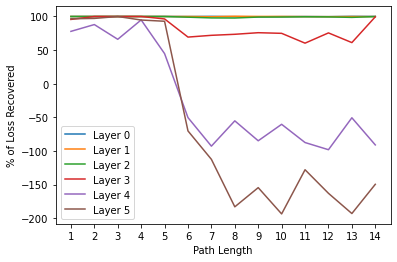

In [31]:
def test_hypothesis_1(path_length, layer=None, position=47):
    model.reset_hooks()

    graph = generate_example_secondary_path(
        n_states=16,
        seed=np.random.randint(0, 1_000_000_000),
        path_length=path_length,
        order="backward",
        second_path_min_length=2
    )
    path = get_inverse_path(graph)
    if layer is None:
        layer = np.random.randint(0, 6)
        
    resampled_graph = get_matching_graph(path[layer], layer+1)
    
    clean_labels, clean_cache  = get_example_cache(graph, model, dataset)
    corrupt_labels, corrupt_cache  = get_example_cache(resampled_graph, model, dataset)
    
    # Patch attention_out at layer, position and do the forward pass again
    def patching_hook(activation, hook):
        activation[:, position, :] = corrupt_cache[hook.name][:, position, :]
        return activation
    model.blocks[layer].hook_attn_out.add_hook(patching_hook)
    #if visualize:
    #    generate_att_table(clean_graph, "Patching Result", "images/test.png", norm=False)
    new_labels, new_cache  = get_example_cache(graph, model, dataset)
    
    original = (clean_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)
    new = (new_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)
    
    random_dist = torch.zeros_like(new)
    #random_dist[3:19] = 100
    random_dist = random_dist.log_softmax(dim=0)
    
    orig_loss = -original[original.argmax()]
    new_loss = -new[original.argmax()]
    rand_loss = -random_dist[original.argmax()]
    #print(original.argmax() == new.argmax())
    
    return orig_loss.item(), new_loss.item(), rand_loss.item()

loss_rec = {}
loss_rec_var = {}

for layer in range(6):
    loss_rec[layer], loss_rec_var[layer] = layer_specific(layer, test_hypothesis_1, n_samples=100)

# Setup figure and axis
fig, ax = plt.subplots()

# Plotting each list in the dictionary
for label, values in loss_rec.items():
    # Adjusting the x-values to start at 1 instead of 0
    x_values = range(1, len(values) + 1)
    ax.plot(x_values, values, label=f"Layer {label}")

# Setting the legend
ax.legend()

# Setting axis names
ax.set_xlabel('Path Length')
ax.set_ylabel(f'% of Loss Recovered')

# Setting ticks on the x-axis to match your data (starting at 1)
plt.xticks(range(1, len(list(loss_rec.values())[0]) + 1))

# Show plot
plt.show()

In [33]:
loss_rec

{0: [99.99993817820479,
  100.0,
  99.9877650047673,
  99.99882296227979,
  100.06517232508887,
  99.90803199989048,
  100.18481180175515,
  99.74845125681779,
  99.52346241767046,
  99.77710048156936,
  99.93826783630661,
  99.76171714487364,
  100.2350130937616,
  100.06734756206879],
 1: [100.00000003352957,
  99.9999998994113,
  99.99999222128393,
  99.99969770489471,
  99.99927573754711,
  100.0441030578436,
  99.6898650315902,
  100.37412086045444,
  100.12216942373438,
  100.09379896221162,
  99.86692871506631,
  99.76714954304718,
  99.9140532002522,
  99.87814335731451],
 2: [99.99961032825676,
  99.99998564971102,
  100.00035523005752,
  100.03044993257637,
  99.98550605283407,
  98.98916091794804,
  97.88901818767967,
  97.72909063604142,
  99.16972283182866,
  99.23706297670861,
  99.5941032893301,
  99.42715063474854,
  98.67610891989553,
  99.93682709876744],
 3: [95.62580051760044,
  99.99993157052405,
  99.99998575016926,
  100.00989301636912,
  96.37578061508906,
  69.

In [35]:
def test_hypothesis_2(path_length, layer=None, position=47):
    model.reset_hooks()

    graph = generate_example_secondary_path(
        n_states=16,
        seed=np.random.randint(0, 1_000_000_000),
        path_length=path_length,
        order="backward",
        second_path_min_length=2
    ) # generate_example(16, np.random.randint(0, 1_000_000_000), path_length=path_length, order="backward")
    path = get_inverse_path(graph)

    if layer is None:
        layer = np.random.randint(0, 6)
        
    resampled_graph = get_matching_graph(path[layer], layer+1)
    
    clean_labels, clean_cache  = get_example_cache(graph, model, dataset)
    corrupt_labels, corrupt_cache  = get_example_cache(resampled_graph, model, dataset)
    
    # Patch attention_out at layer, position and do the forward pass again
    def patching_hook(activation, hook):
        layer_name = int(hook.name.split(".")[1])
        register_tokens = [36,38,39,41,42,44,45]
        # Recompute the attn_hook_out without the register tokens from a different input
        corrupt_values = corrupt_cache[f"blocks.{layer}.attn.hook_v"] # B x P x H x D
        corrupt_pattern = corrupt_cache[f"blocks.{layer}.attn.hook_pattern"]
        corrupt_vp = torch.einsum("bqhd,bhpq->bpqhd", corrupt_values, corrupt_pattern)
        
        clean_values = clean_cache[f"blocks.{layer}.attn.hook_v"] # B x P x H x D
        clean_pattern = clean_cache[f"blocks.{layer}.attn.hook_pattern"]
        clean_vp = torch.einsum("bqhd,bhpq->bpqhd", clean_values, clean_pattern)
        
        corrupt_vp[:, :, register_tokens] = clean_vp[:, :, register_tokens]
        corrupt_z = corrupt_vp.sum(dim=2)
        # Compute the B x H x P x P x D s.t. summing over second p gives you v
        activation[:, position] = corrupt_z[:, position]
        return activation

    model.blocks[layer].attn.hook_z.add_hook(patching_hook)
    #if visualize:
    #    generate_att_table(clean_graph, "Patching Result", "images/test.png", norm=False)
    new_labels, new_cache  = get_example_cache(graph, model, dataset)
    
    original = (clean_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)
    new = (new_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)

    random_dist = torch.zeros_like(new)
    #random_dist[3:19] = 100
    random_dist = random_dist.log_softmax(dim=0)
    
    orig_loss = -original[original.argmax()]
    new_loss = -new[original.argmax()]
    rand_loss = -random_dist[original.argmax()]
    #print(original.argmax() == new.argmax())
    
    return orig_loss.item(), new_loss.item(), rand_loss.item()


loss_rec =  {layer: layer_specific(layer, test_hypothesis_2) for layer in range(6)}
# Setup figure and axis
fig, ax = plt.subplots()

# Plotting each list in the dictionary
for label, values in loss_rec.items():
    # Adjusting the x-values to start at 1 instead of 0
    x_values = range(1, len(values) + 1)
    ax.plot(x_values, values, label=f"Layer {label}")

# Setting the legend
ax.legend()

# Setting axis names
ax.set_xlabel('Path Length')
ax.set_ylabel(f'% of Loss Recovered')

# Setting ticks on the x-axis to match your data (starting at 1)
plt.xticks(range(1, len(list(loss_rec.values())[0]) + 1))

# Show plot
plt.show()
    

In [ ]:
def test_hypothesis_3(path_length, layer=None, position=47):
    model.reset_hooks()

    graph = generate_example_secondary_path(
        n_states=16,
        seed=np.random.randint(0, 1_000_000_000),
        path_length=path_length,
        order="backward",
        second_path_min_length=2
    ) # generate_example(16, np.random.randint(0, 1_000_000_000), path_length=path_length, order="backward")
    path = get_inverse_path(graph)
    if layer is None:
        layer = np.random.randint(0, 6)
        
    resampled_graph = get_matching_graph(path[layer], layer+1)
    
    clean_labels, clean_cache  = get_example_cache(graph, model, dataset)
    corrupt_labels, corrupt_cache  = get_example_cache(resampled_graph, model, dataset)
    
    # Patch attention_out at layer, position and do the forward pass again
    def patching_hook(activation, hook):
        layer_name = int(hook.name.split(".")[1])
        register_tokens = [i for i in range(46) if (i+2)%3 == 0] + [36,38,39,41,42,44,45]
        # Recompute the attn_hook_out without the register tokens from a different input
        corrupt_values = corrupt_cache[f"blocks.{layer}.attn.hook_v"] # B x P x H x D
        corrupt_pattern = corrupt_cache[f"blocks.{layer}.attn.hook_pattern"]
        corrupt_vp = torch.einsum("bqhd,bhpq->bpqhd", corrupt_values, corrupt_pattern)
        
        clean_values = clean_cache[f"blocks.{layer}.attn.hook_v"] # B x P x H x D
        clean_pattern = clean_cache[f"blocks.{layer}.attn.hook_pattern"]
        clean_vp = torch.einsum("bqhd,bhpq->bpqhd", clean_values, clean_pattern)
        
        corrupt_vp[:, :, register_tokens] = clean_vp[:, :, register_tokens]
        corrupt_z = corrupt_vp.sum(dim=2)
        # Compute the B x H x P x P x D s.t. summing over second p gives you v
        activation[:, position] = corrupt_z[:, position]
        return activation

    model.blocks[layer].attn.hook_z.add_hook(patching_hook)
    #if visualize:
    #    generate_att_table(clean_graph, "Patching Result", "images/test.png", norm=False)
    new_labels, new_cache  = get_example_cache(graph, model, dataset)
    
    original = (clean_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)
    new = (new_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)

    random_dist = torch.zeros_like(new)
    #random_dist[3:19] = 100
    random_dist = random_dist.log_softmax(dim=0)
    
    orig_loss = -original[original.argmax()]
    new_loss = -new[original.argmax()]
    rand_loss = -random_dist[original.argmax()]
    #print(original.argmax() == new.argmax())
    
    return orig_loss.item(), new_loss.item(), rand_loss.item()


loss_rec =  {layer: layer_specific(layer, test_hypothesis_3, n_samples) for layer in range(6)}
# Setup figure and axis
fig, ax = plt.subplots()

# Plotting each list in the dictionary
for label, values in loss_rec.items():
    # Adjusting the x-values to start at 1 instead of 0
    x_values = range(1, len(values) + 1)
    ax.plot(x_values, values, label=f"Layer {label}")

# Setting the legend
ax.legend()

# Setting axis names
ax.set_xlabel('Path Length')
ax.set_ylabel(f'% of Loss Recovered')

# Setting ticks on the x-axis to match your data (starting at 1)
plt.xticks(range(1, len(list(loss_rec.values())[0]) + 1))

# Show plot
plt.show()
    

In [ ]:
model.reset_hooks()
layer=3
path_length=10
position=47

graph = generate_example(16,np.random.randint(0, 1000000000), path_length=path_length, order="backward")
generate_att_table(graph, "Patching Result", "images/test.png", pos=47, norm=False)

path = get_inverse_path(graph)
if layer is None:
    layer = np.random.randint(0, 6)
resampled_graph = get_matching_graph(path[layer], layer+1)

parse_example(graph)
plt.show()
parse_example(resampled_graph)
plt.show()


clean_labels, clean_cache  = get_example_cache(graph, model, dataset)
corrupt_labels, corrupt_cache  = get_example_cache(resampled_graph, model, dataset)

# Patch attention_out at layer, position and do the forward pass again
def patching_hook(activation, hook):
    layer_name = int(hook.name.split(".")[1])
    register_tokens = [i for i in range(46) if (i+2)%3 == 0] # [i for i in range(47) if (i+2)%3!=0 or i==46]
    # Recompute the attn_hook_out without the register tokens from a different input
    corrupt_values = corrupt_cache[f"blocks.{layer}.attn.hook_v"] # B x P x H x D
    corrupt_pattern = corrupt_cache[f"blocks.{layer}.attn.hook_pattern"]
    corrupt_vp = torch.einsum("bqhd,bhpq->bpqhd", corrupt_values, corrupt_pattern)
    
    clean_values = clean_cache[f"blocks.{layer}.attn.hook_v"] # B x P x H x D
    clean_pattern = clean_cache[f"blocks.{layer}.attn.hook_pattern"]
    clean_vp = torch.einsum("bqhd,bhpq->bpqhd", clean_values, clean_pattern)
    
    corrupt_vp[:, position, register_tokens] = clean_vp[:, position, register_tokens]
    corrupt_z = corrupt_vp.sum(dim=2)
    # Compute the B x H x P x P x D s.t. summing over second p gives you v
    activation[:, position] = corrupt_z[:, position]
    return activation


model.blocks[layer].attn.hook_z.add_hook(patching_hook)
new_labels, new_cache  = get_example_cache(graph, model, dataset)

original = (clean_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)
new = (new_cache["ln_final.hook_normalized"] @ model.W_U)[0, position].log_softmax(dim=0)

print("Orig", dataset.idx2tokens[original.argmax()])
print("New ", dataset.idx2tokens[new.argmax()])

generate_att_table(graph, "Patching Result", "images/test.png", pos=47, norm=False)


In [ ]:
model.reset_hooks()

graph = generate_example(16, np.random.randint(0, 1_000_000_000), path_length=1, order="backward")
path = get_inverse_path(graph)
layer=3
path_length=2

if layer > path_length:
    resampled_graph = get_matching_graph(path[layer], layer+1)
else:
    resampled_graph = get_matching_graph(path[layer], layer+1)

generate_att_table(graph, "Pre-Patching", "images/test.png", norm=False)

parse_example(graph)
plt.show()

parse_example(resampled_graph)
plt.show()

clean_labels, clean_cache  = get_example_cache(graph, model, dataset)
corrupt_labels, corrupt_cache  = get_example_cache(resampled_graph, model, dataset)

# Patch attention_out at layer, position and do the forward pass again
def patching_hook(activation, hook):
    activation[:, 47, :] = corrupt_cache[hook.name][:, 47, :]
    return activation
model.blocks[layer].hook_attn_out.add_hook(patching_hook)

generate_att_table(graph, "Patching Result", "images/test.png", norm=False)
new_labels, new_cache  = get_example_cache(graph, model, dataset)

original = (clean_cache["ln_final.hook_normalized"] @ model.W_U)[0, 47].log_softmax(dim=0)
new = (new_cache["ln_final.hook_normalized"] @ model.W_U)[0, 47].log_softmax(dim=0)

In [ ]:
#Without a specific layer

for pl in range(1, 15):
    
    orig_losses = []
    new_losses = []
    rand_losses = []
    
    n_samples = 1_000
    
    for i in range(n_samples):
        orig_loss, new_loss, rand_loss = test_hypothesis_1(pl, use_children=False)
        orig_losses.append(orig_loss)
        new_losses.append(new_loss)
        rand_losses.append(rand_loss)
    
    
    loss_rec = ((sum(new_losses) / n_samples) - (sum(rand_losses) / n_samples)) / ((sum(orig_losses) / n_samples) - (sum(rand_losses) / n_samples)) * 100
    print(pl, loss_rec)

In [ ]:
def attn_out_patching(clean_graph, corrupt_graph, layer, position, visualize=False):
    # Get clean and corrupted labels
    clean_labels, clean_cache  = get_example_cache(clean_graph, model, dataset)
    corrupt_labels, corrupt_cache  = get_example_cache(corrupt_graph, model, dataset)
    # Patch attention_out at layer, position and do the forward pass again
    def patching_hook(activation, hook):
        activation[:, position, :] = corrupt_cache[hook.name][:, position, :]
        return activation
    model.blocks[layer].hook_attn_out.add_hook(patching_hook)
    if visualize:
        generate_att_table(clean_graph, "Patching Result", "images/test.png", norm=False)
    new_labels, new_cache  = get_example_cache(clean_graph, model, dataset)
    return new_cache

In [ ]:
model.reset_hooks()
ex1 = generate_example(16, 3424, order="backward")
parse_example(ex1)
plt.show()

ex2 = generate_example(16, 3422344, order="backward")
parse_example(ex2)
plt.show()

attn_out_patching(ex1, ex2, 1, 47)[47:]

### Head Compositions


In [ ]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T


plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

plt.savefig('filename.png', dpi=300)


In [ ]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.d_vocab)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.d_vocab):
        
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_E[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        scores[q, k] = q_out @ k_out.T


plt.imshow(scores.softmax(dim=1)[:, :].detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.gca().set_ylim(top=35)
plt.gca().set_ylim(bottom=47)

plt.gca().set_xlim(left=19)
plt.gca().set_xlim(right=19+16)
plt.xticks(ticks=range(19,19+16), labels = [dataset.idx2tokens[i] for i in range(19, 19+16) ] )

plt.ylabel("Position Embedding in Query")
plt.xlabel("Token Embedding in Key")

plt.savefig('filename.png', dpi=300)


### Figuring out the main algo

In [ ]:
model.reset_hooks()

counter = 0
for i in range(1000):
    model.reset_hooks()
    ex = generate_example_secondary_path(16, np.random.randint(0, 1_000_000_000), path_length=7, second_path_min_length=2, order="backward")
    #print(eval_model(model, dataset, ex))
    if is_model_correct(model, dataset, ex):
        counter+=1
        
counter/1000*100


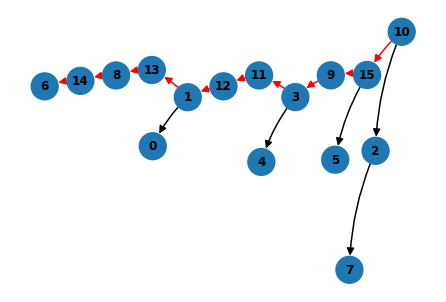

In [24]:
model.reset_hooks()
ex = generate_example_secondary_path(16, np.random.randint(0, 1_000_000_000), path_length=10, second_path_min_length=2, order="backward")
#print(eval_model(model, dataset, ex))
assert is_model_correct(model, dataset, ex)
parse_example(ex)

labels, cache = get_example_cache(ex, model, dataset)


In [25]:
important_pos = [1 + 3*i for i in range(13)] # + [36, 38, 39, 41, 42, 44, 46] # + [47]
M = model.blocks[5].attn.W_O @ model.W_U
x = cache["blocks.5.attn.hook_v"][0, important_pos, 0] @ M
dataset.idx2tokens[x.sum(1).argmax()]


'>15'

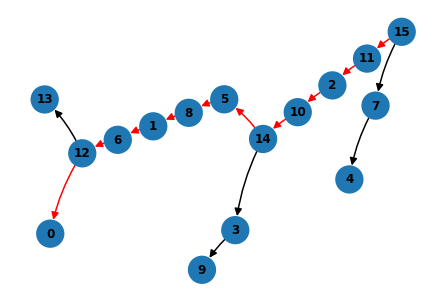

In [26]:

model.reset_hooks()
ex = generate_example_secondary_path(16, np.random.randint(0, 1_000_000_000), path_length=10, second_path_min_length=2, order="backward")
#print(eval_model(model, dataset, ex))
assert is_model_correct(model, dataset, ex)
parse_example(ex)

labels, cache = get_example_cache(ex, model, dataset)


In [33]:
cache["blocks.4.attn.hook_v"][0, important_pos, 0].shape

torch.Size([16, 128])

In [36]:
cache["blocks.4.attn.hook_pattern"][0, 0, 47, important_pos]

tensor([0.0115, 0.0335, 0.0442, 0.0418, 0.2206, 0.0668, 0.0230, 0.0332, 0.0916,
        0.0462, 0.0243, 0.0555, 0.0173, 0.0020, 0.0024, 0.0293],
       device='cuda:0')

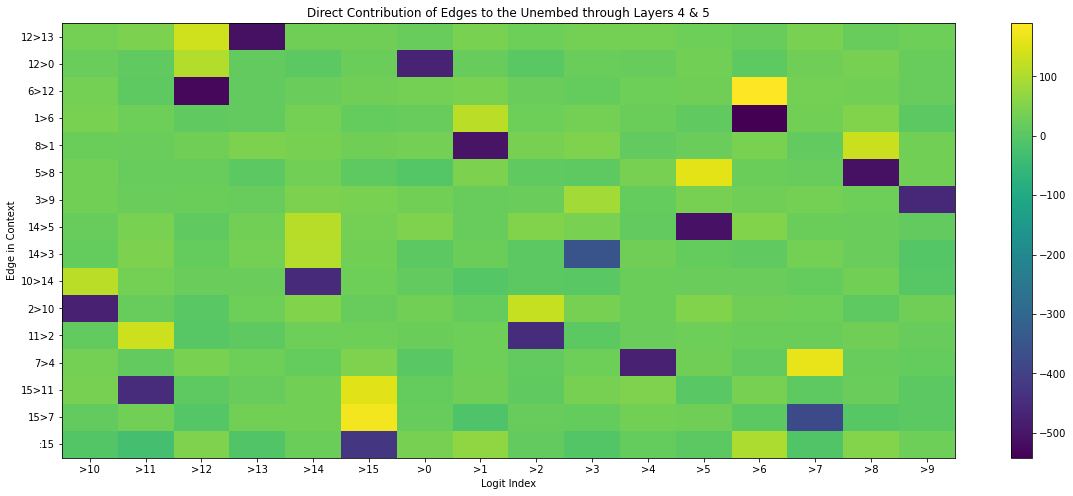

In [32]:
important_pos = [1 + 3*i for i in range(15)] + [47] # + [36, 38, 39, 41, 42, 44, 46] # + [47]
M_4 = model.blocks[4].attn.W_O @ model.W_U
M_5 = model.blocks[5].attn.W_O @ model.W_U
X_4 = cache["blocks.4.attn.hook_v"][0, important_pos, 0]
X_5 = cache["blocks.5.attn.hook_v"][0, important_pos, 0]
out = (X_4 @ M_4) + (X_5 @ M_5)

x_labels = dataset.idx2tokens[3:19]
y_labels = [labels[i-1]+labels[i] for i in important_pos]

# Create the heatmap using imshow
plt.figure(figsize=(20, 8))    # Set the figure size as you like

plt.imshow(out[0, :, 3:19].cpu().detach(), cmap='viridis', aspect='auto')  # Choose a colormap that suits your preference

# Configure the ticks
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)  # Set x-axis labels
plt.yticks(ticks=np.arange(out.shape[1]), labels=y_labels)  # Optionally, set y-axis labels if needed

# Adding a colorbar to show the scale
plt.colorbar()

# Optional enhancements
plt.xlabel('Logit Index')
plt.ylabel('Edge in Context')
plt.title('Direct Contribution of Edges to the Unembed through Layers 4 & 5')

# Show the plot
plt.show()


In [ ]:
important_pos = [1 + 3*i for i in range(13)] + [47] # + [36, 38, 39, 41, 42, 44, 46] # + [47]
M_4 = model.blocks[4].attn.W_O @ model.W_U
M_5 = model.blocks[5].attn.W_O @ model.W_U
X_4 = cache["blocks.4.attn.hook_v"][0, important_pos, 0]
X_5 = cache["blocks.5.attn.hook_v"][0, important_pos, 0]
out = (X_4 @ M_4) + (X_5 @ M_5)

x_labels = dataset.idx2tokens[3:19]
y_labels = [labels[i-1]+labels[i] for i in important_pos]

# Corrects 'out' to 'data_np' in the if condition
data_np = out[0, :, 3:19].cpu().detach().numpy() if isinstance(out[0], torch.Tensor) else out[0]
data_np = data_np - data_np.mean()
# Calculate the sum of values for each column
column_sum = np.sum(data_np, axis=0)[np.newaxis, :]

# Create subplots: One for the column sum heatmap and one for the main data heatmap
# Increased vertical_spacing and adjusted row_heights for a thinner sum row plot
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.1,  # Increased spacing
                    subplot_titles=('Column Sum', 'Heatmap of 13 x 35 Matrix'),
                    row_heights=[0.1, 0.9],  # Make sum row thinner
                    specs=[[{"type": "heatmap"}], [{"type": "heatmap"}]])

# Add the column sum heatmap as a subplot
fig.add_trace(
    go.Heatmap(
        z=column_sum, x=x_labels, colorscale='RdBu',
        colorbar=dict(len=0.1, y=0.95),  # Adjust colorbar to match thinner sum row
        showscale=False  # Because adding individual scale for sum row doesn't vertically align well
    ),
    row=1, col=1
)

# Add the main heatmap as a subplot
fig.add_trace(
    go.Heatmap(
        z=data_np, x=x_labels, y=y_labels, colorscale='RdBu', w
    ),
    row=2, col=1
)

# Update the layout to adjust the height of the figure
fig.update_layout(
    height=900,  # Adjusted height to accommodate increased vertical spacing
    width=1000,  
    title_text='Column Sum and Heatmap'
)

fig.show()


In [ ]:
data.shape

In [ ]:
for l in range(model.cfg.n_layers):
    top_t = (cache[f"blocks.{l}.hook_attn_out"][:, 47] @ model.W_U).argmax()
    print(dataset.idx2tokens[top_t])

In [ ]:
M = (model.blocks[5].attn.W_O @ model.W_U)[0]
important_pos = [1 + 3*i for i in range(16)] + [36, 38, 39, 41, 42, 44, 46]
contribs = cache["blocks.5.attn.hook_v"][0, important_pos, 0] @ M

In [ ]:
dataset.idx2tokens[contribs.sum(dim=0).argmax()]

### Idk what to call this so far


In [ ]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_pos[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        if k < q:
            scores[q, k] = q_out @ k_out.T


plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

plt.savefig('filename.png', dpi=300)


In [ ]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.d_vocab)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.d_vocab):
        
        q_out = model.blocks[0].ln1( model.W_pos[q:q+1] ) @ model.blocks[0].attn.W_Q[0] + model.blocks[0].attn.b_Q
        k_out = model.blocks[0].ln1( model.W_E[k:k+1] ) @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        scores[q, k] = q_out @ k_out.T


plt.imshow(scores.softmax(dim=1)[:, :].detach(), cmap="RdBu", vmin=-1, vmax=1)
plt.gca().set_ylim(top=35)
plt.gca().set_ylim(bottom=47)

plt.gca().set_xlim(left=19)
plt.gca().set_xlim(right=19+16)
plt.xticks(ticks=range(19,19+16), labels = [dataset.idx2tokens[i] for i in range(19, 19+16) ] )

plt.ylabel("Position Embedding in Query")
plt.xlabel("Token Embedding in Key")

plt.savefig('filename.png', dpi=300)


In [ ]:
dataset.idx2tokens[19:19+16]

In [ ]:
scores2 = torch.zeros(16, 16)

for i in range(16):
    goal_rep = model.W_E[dataset.tokens2idx[str(i)]][None, :] #+ model.W_pos[45:46]
    v1 = goal_rep @ model.blocks[0].attn.W_V[0] # + model.blocks[0].attn.b_V
    o1 = v1 @ model.blocks[0].attn.W_O[0]  + model.blocks[0].attn.b_O
    
    
    o1 = model.blocks[0].ln2(o1)
    o1 = o1 + model.blocks[0].mlp(o1[None, :])[0]

    for j in range(16):
        key = model.W_E[dataset.tokens2idx[">"+str(j)]][None, :] @ model.blocks[1].attn.W_K[0] # + model.blocks[1].attn.b_K
        query = o1 @ model.blocks[1].attn.W_Q[0] #+ model.blocks[1].attn.b_Q
        scores2[i, j] = query @ key.T


plt.imshow((scores2).softmax(-1).detach())
plt.title("K-Compositon Backtracking Mechanism")

plt.xticks(list(range(16)), [str(i) for i in range(16)])
plt.yticks(list(range(16)), [">" + str(i) for i in range(16)])

plt.xlabel("Query Token (Goal Representation)")
plt.ylabel("Key Token")

plt.savefig('filename.png', dpi=300)
